In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from data import read_preprocessed_data
from sklearn.mixture import GaussianMixture 
from sklearn.decomposition import PCA
import seaborn as sns

color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]

data_scaled = read_preprocessed_data()

/home/milosz/Desktop/code/student-performance/data/marketing_campaign.csv


In [3]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=3,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla trzech klastrów z wizualizacją PCA ')

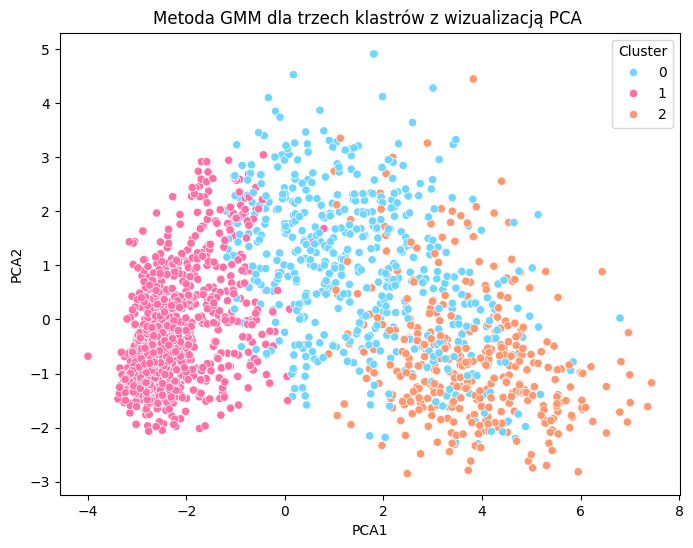

In [4]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette[:-1]
)
plt.title("Metoda GMM dla trzech klastrów z wizualizacją PCA ")

In [5]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów

kl1 = cluster_summary.iloc[1].values.tolist()
cluster_summary.transpose()

/home/milosz/Desktop/code/student-performance/data/marketing_campaign.csv


Cluster,0,1,2
Income,62714.003466,35209.285038,75862.637532
Kidhome,0.10052,0.774621,0.023136
Teenhome,0.731369,0.473485,0.200514
Recency,46.994801,49.303977,50.948586
MntWines,446.523397,49.409091,655.305913
MntFruits,35.561102,5.466856,65.813107
MntMeatProducts,169.511265,26.340909,494.977425
MntFishProducts,48.767474,8.214962,98.854594
MntSweetProducts,36.259827,5.573864,67.52711
MntGoldProds,65.435714,17.139205,72.822155


In [6]:
 #model mieszanin gaussa

gmm = GaussianMixture(
    # Stosujemy model mieszanin gaussa dla wybranej liczby klastrów
    n_components=4,          
    covariance_type='tied',  
    # Używamy random_state = 42, aby zapewnić, że klastry będą takie same z każdym uruchomieniem
    random_state=42
)
data_scaled['Cluster'] = gmm.fit_predict(data_scaled)

Text(0.5, 1.0, 'Metoda GMM dla czterech klastrów z wizualizacją PCA ')

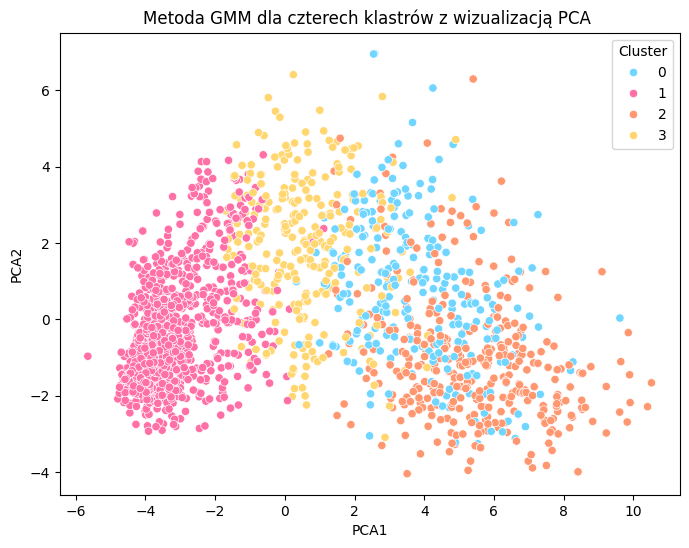

In [7]:
# Dwuwymiarowa wizualizacja danych za pomocą analizy głównych składowych (PCA)
pca = PCA(n_components=2)
color_palette = ["#70d6ff", "#ff70a6", "#ff9770", "#ffd670"]
pca_components = pca.fit_transform(data_scaled.drop("Cluster", axis=1))
data_scaled["PCA1"] = pca_components[:, 0]
data_scaled["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=data_scaled, x="PCA1", y="PCA2", hue="Cluster", palette=color_palette
)
plt.title("Metoda GMM dla czterech klastrów z wizualizacją PCA ")

In [8]:
# Wczytujemy nieustandaryzowane dane
original_data = read_preprocessed_data(std=False, le=False)

# Kopiujemy kolumnę "Cluster"
original_data["Cluster"] = data_scaled["Cluster"]

# Obliczamy średnie dla danych numerycznych i grupujemy dane według klastrów
cluster_summary = original_data.groupby("Cluster").mean(numeric_only=True)

# Obliczamy mediany dla danych kategorycznych
object_cols = original_data.select_dtypes(include="object").columns
for col in object_cols:
    mode_per_cluster = original_data.groupby("Cluster")[col].agg(lambda x: x.mode()[0])
    cluster_summary[col + "_mode"] = mode_per_cluster


#Dla łatwiejszej analizy wydatków zliczamy procent przychodów jaki stanowią wydatki (pozwala identyfikować rozrzutnych klientów)
original_data["Spending_To_Income_Ratio"] = original_data["Spent"]/original_data["Income"]
cluster_summary["Spending_To_Income_Ratio_Mode"] = original_data.groupby("Cluster")["Spending_To_Income_Ratio"].agg(lambda x: x.mode()[0])

# Zliczamy ilość danych w klastrze
cluster_summary["Count"] = original_data["Cluster"].value_counts().sort_index()
# Podsumowanie klastrów
cluster_summary.transpose()


/home/milosz/Desktop/code/student-performance/data/marketing_campaign.csv


Cluster,0,1,2,3
Income,67997.79021,35209.285038,75862.637532,57521.003436
Kidhome,0.101399,0.774621,0.023136,0.099656
Teenhome,0.611888,0.473485,0.200514,0.848797
Recency,45.36014,49.303977,50.948586,48.601375
MntWines,535.423077,49.409091,655.305913,359.151203
MntFruits,53.00356,5.466856,65.813107,18.418343
MntMeatProducts,222.293706,26.340909,494.977425,117.635739
MntFishProducts,69.91587,8.214962,98.854594,27.982453
MntSweetProducts,51.214791,5.573864,67.52711,21.561821
MntGoldProds,75.301302,17.139205,72.822155,55.739637


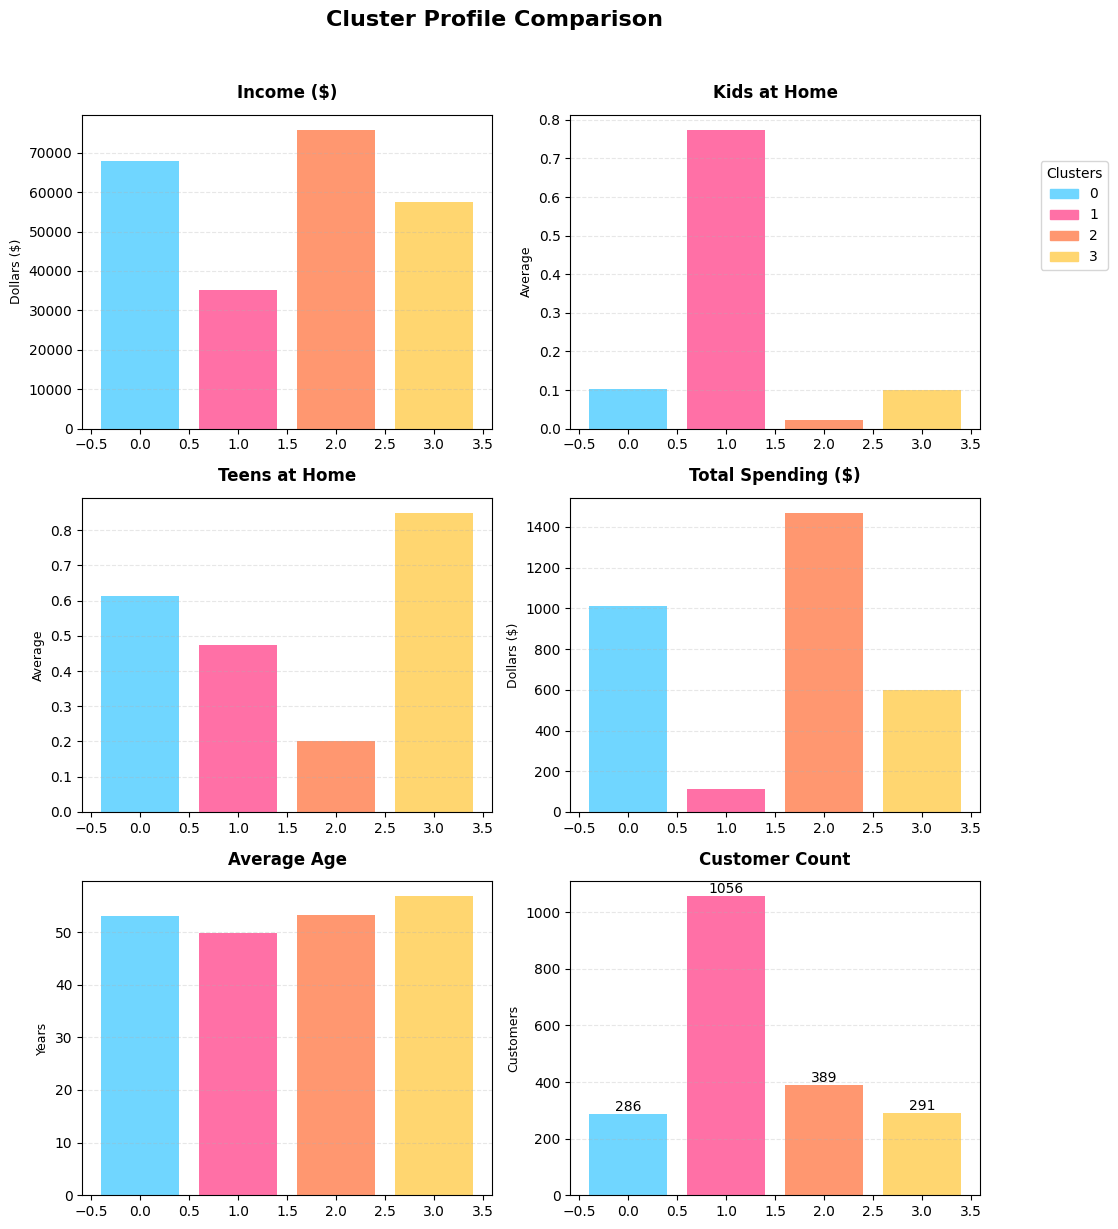

In [9]:
# Data preparation
variables = ['Income', 'Kidhome', 'Teenhome', 'Spent', 'Age', 'Count']
titles = ['Income ($)', 'Kids at Home', 'Teens at Home', 'Total Spending ($)', 'Average Age', 'Customer Count']
cluster_labels = cluster_summary.index

# Create figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.suptitle('Cluster Profile Comparison', fontsize=16, y=1.02, weight='bold')

# Plot each variable
for ax, var, title in zip(axes.flatten(), variables, titles):
    values = cluster_summary[var]
    
    bars = ax.bar(cluster_labels, values, color=color_palette)
    ax.set_title(title, pad=12, weight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add value labels for Count
    if var == 'Count':
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=10)
    
    # Format y-axis for monetary values
    if var in ['Income', 'Spent']:
        ax.set_ylabel('Dollars ($)', fontsize=9)
    elif var == 'Age':
        ax.set_ylabel('Years', fontsize=9)
    elif var == 'Count':
        ax.set_ylabel('Customers', fontsize=9)
    else:
        ax.set_ylabel('Average', fontsize=9)

plt.tight_layout()

# Add legend once
handles = [plt.Rectangle((0,0),1,1, color=color) 
           for color in color_palette]
fig.legend(handles, cluster_labels, 
           title='Clusters', 
           loc='upper right', 
           bbox_to_anchor=(1.12, 0.9))
